<h3 style="text-align: center;"><b>Linear models and optimization methods</b></h3>

---

В данной работе мы реализуем свой класс логистической регрессии для бинарной классификации, а также логистическую регрессию с регуляризацией.

# Import Libraries

---

In [15]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
from matplotlib import cm
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [2]:
np.random.seed(42)

# Gradient Descent

---

Рассмотрим функцию от двух переменных: $f(x, y) = \sin^2 x + \sin^2 y$  

In [5]:
def f(x: np.array):
    return np.sum(np.sin(x)**2)

Обратим внимание, что $x$ - numpy-array вектор длины 2.

**Что мы хотим?**
Мы хотим найти минимум этой функции (в машинному обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $x_1$ и $x_2$ такие, что при них значение $f(x_1,x_2)$ минимально, то есть *точку экстремума*.  
  
**Как мы будем искать эту точку?**
Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

Реализуем функцию, которая будет осуществлять градиентный спуск для функции $f$:

_**Примечание:** Нам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы._

$$f(x, y) = \sin^2(x) + \sin^2(y)$$

$$f'(x, y) = (\sin^2(x) + \sin^2(y))'$$

$$\frac{\delta f(x, y)}{\delta x} = 2 \sin(x) (sin(x))' + 0 = 2 \sin(x) cos(x) = \sin(2x)$$
$$\frac{\delta f(x, y)}{\delta y} = 0 + 2 \sin(y) (sin(y))' = 2 \sin(y) cos(y) = \sin(2y)$$


In [8]:
def grad_f(x: np.array) -> np.array:
    """
    :param x: np.array[2]: float вектор длины 2
    :return: np.array[2]: float вектор длины 2
    """
    return np.sin(2 * x)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение:

In [9]:
assert np.allclose(grad_f(np.array([1, 2])),
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [10]:
def grad_descent_2d(f, grad_f, lr: float, num_iter: int = 100, x0: np.ndarray = None) -> np.ndarray:
    """
    :param f: скалярная функция двух переменных
    :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
    :param lr: learning rate алгоритма
    :param num_iter: количество итераций градиентного спуска
    :param x0: np.array[float, float] начальная точка
    :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    x0 = np.random.random(2) if x0 is None else x0
    history = []

    curr_x = x0.copy()
    for _ in range(num_iter):
        entry = np.hstack((curr_x, f(curr_x)))
        history.append(entry)

        curr_x -= lr * grad_f(curr_x)

    return np.vstack(history)

Тестируем написанную функцию:

In [11]:
steps = grad_descent_2d(f, grad_f, lr=0.1, num_iter=20)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $x_1, x_2, f(x_1, x_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму.

(Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_x_1, cur\_x_2, f(cur\_x_1, cur\_x_2)$ в `steps` в процессе спуска)

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точку минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [12]:
steps

array([[3.74540119e-01, 9.50714306e-01, 7.96162814e-01],
       [3.06443570e-01, 8.56130580e-01, 6.61501405e-01],
       [2.48920419e-01, 7.57129527e-01, 5.32438585e-01],
       [2.01167461e-01, 6.57289308e-01, 4.13213611e-01],
       [1.62010673e-01, 5.60553766e-01, 3.08675973e-01],
       [1.30172552e-01, 4.70495524e-01, 2.22355696e-01],
       [1.04431147e-01, 3.89681303e-01, 1.55185446e-01],
       [8.36964420e-02, 3.19398688e-01, 1.05582063e-01],
       [6.70352177e-02, 2.59775649e-01, 7.04659717e-02],
       [5.36683031e-02, 2.10126580e-01, 4.63846811e-02],
       [4.29552413e-02, 1.69327420e-01, 3.02428152e-02],
       [3.43747570e-02, 1.36105556e-01, 1.95917748e-02],
       [2.75052200e-02, 1.09219378e-01, 1.26378615e-02],
       [2.20069501e-02, 8.75488032e-02, 8.12945761e-03],
       [1.76069810e-02, 7.01283780e-02, 5.21990623e-03],
       [1.40863125e-02, 5.61486426e-02, 3.34776943e-03],
       [1.12694227e-02, 4.49425016e-02, 2.14546343e-03],
       [9.01572898e-03, 3.59660

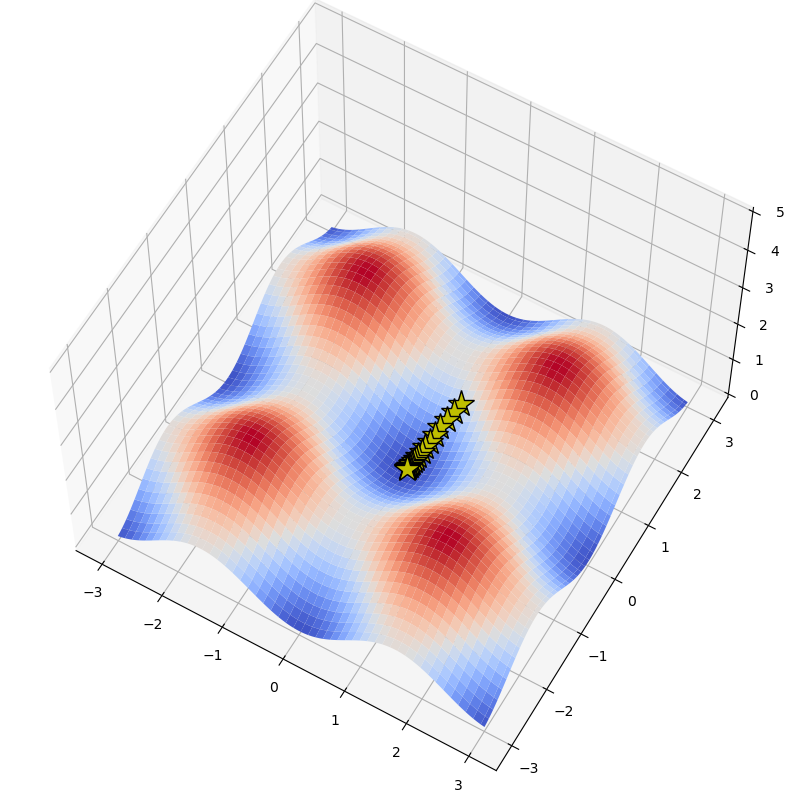

In [22]:
path = []

X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

fig = plt.figure(figsize=(16, 10))
# ax = fig.gca(projection='3d')
# ax = fig.add_subplot(projection='3d')
ax = plt.axes(projection="3d")

zs = np.array([f(np.array([x,y])) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(
    X, Y, Z, 
    cmap=cm.coolwarm, 
    zorder=2
)
ax.plot(
    xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
    marker="*", 
    markersize=20, 
    zorder=3,
    markerfacecolor="y", 
    lw=3, 
    c="black"
)

ax.set_zlim(0, 5)
ax.view_init(elev=60)

plt.show()

Посмотрим на график значений функции от шага:

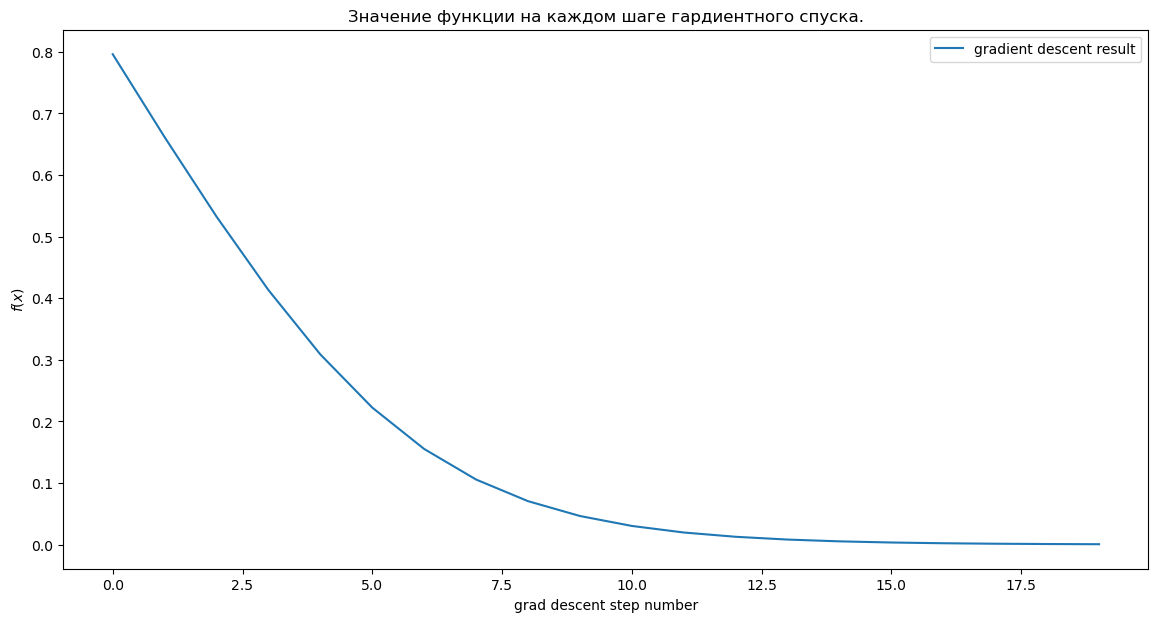

In [24]:
plt.figure(figsize=(14,7))

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")

plt.title("Значение функции на каждом шаге гардиентного спуска.")
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.legend()

plt.show()

Когда мы используем градиентный спуск, всегда необходимо удостовериться в сходимости. К сожалению для большинства моделей не получится построить 3D график, поэтому обязательно нужно смотреть на то, как менялся loss на каждом шаге градиентного спуска.

# Batch Generator

---

**Мотивация:** 
Раньше мы выбирали *batch_size* случайных строчек на каждом шаге, но у такого подхода есть недостатки. Основной минус заключается в том, что некоторые строчки из обучающего датасета могут попадаться значительно реже, чем другие.

Чтобы это исправить обучение делят на эпохи. Мы хотим, чтобы в течение одной эпохи модель обучилась на каждом примере один раз. Для этого нужно перемешать строчки в датасете и каждый раз брать очередные *batch_size* строчек.

Может так получится, что размер датасета не делится на *batch_size*, тогда последний батч будет состоять из нескольких последних строк и его размер будет меньше, чем *batch_size*. Такой батч иногда выкидывают и просто не используют. Именно так мы и поступим в этом задании.

Напишем генератор батчей, который будет принимать на вход признаки, ответы и размер батча. Генератор должен возвращать tuple из ($X_{batch}$, $y_{batch}$). Если размер датасета не делится на batch_size, то **последний маленький батч не будем возвращать**. Чтобы не перемешивать сам датасет воспользуемся np.random.permutation(len(X)).


Подробнее про Python генераторы здесь:

- [Документация](https://wiki.python.org/moin/Generators)
- [Описание на русском](https://pythoner.name/list-generator)


In [29]:
def generate_batches(X_: np.array, y_: np.array, batch_size: int) -> tuple:
    """
    :param X_: np.array[n_objects, n_features] --- матрица объекты-признаки
    :param y_: np.array[n_objects] --- вектор целевых переменных
    :param batch_size: int --- размер батча
    """
    assert len(X_) == len(y_)
    np.random.seed(42)

    X_ = np.array(X_)
    y_ = np.array(y_)
    perm = np.random.permutation(len(X_))

    for batch_start in range(len(X_) // batch_size):
        batch_mask = perm[batch_start * batch_size:(batch_start + 1) * batch_size]
        yield X_[batch_mask], y_[batch_mask]

Проверим, что наш генератор батчей перемешивает датасет и каждый элемент встречается один раз:

In [31]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

X_reconstructed, y_reconstructed = [], []
for X_batch, y_batch in generate_batches(X_fake, y_fake, 10):
    X_reconstructed.append(X_batch)
    y_reconstructed.append(y_batch)

X_reconstructed = np.concatenate(X_reconstructed)
y_reconstructed = np.concatenate(y_reconstructed)

assert (X_fake != X_reconstructed).all(), "Что-то не так!"
assert (y_fake != y_reconstructed).all(), "Что-то не так!"

assert (np.sort(X_reconstructed, axis=0) == X_fake).all(), "Что-то не так!"

Попробуем теперь *batch_size* не делящий размер датасета.

In [32]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

num_batches = 0
for X_batch, y_batch in generate_batches(X_fake, y_fake, 7):
    num_batches += 1

assert num_batches == len(X_fake) // 7, "Что-то не так!"

# Linear Regression

---

В этом пункте мы напишем класс логистической регрессии, пока без добавления в функцию потерь регуляризационных слагаемых.

Воспользуемся оптимизацией с помощью SGD, используя генератор батчей, который мы написали выше.


Реализуем методы ``fit`` и ``get_grad`` класса ``MyLogisticRegression``.

**Формулы:**

$$Loss(y, p) = -\sum_{i=1}^{l} (y_i \log (p_i) + (1 - y_i) \log (1 - p_i))$$


$$ \frac{\partial L}{\partial w} = X^T (p - y)$$


In [52]:
def logit(x_, w_):
    return np.dot(x_, w_)

def sigmoid(h_):
    return 1. / (1 + np.exp(-h_))

In [42]:
class MyLogisticRegression(object):
    def __init__(self):
        self.w = None
    
    @staticmethod
    def _add_ones(X_):
        return np.concatenate((np.ones((X_.shape[0], 1)), X_), axis=1)

    @staticmethod
    def __loss(y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

    def _predict_proba_internal(self, X_):
        """
        Используем эту функцию вместо predict_proba, поскольку
        predict_proba конкатенирует вход с вектором из единиц, что не всегда удобно
        для внутренней логики нашей программы
        """
        return sigmoid(logit(X_, self.w))
    
    @staticmethod
    def get_grad(X_batch_, y_batch_, predictions):
        """
        param X_batch_: np.array[batch_size, n_features + 1] --- матрица объекты-признаки
        param y_batch_: np.array[batch_size] --- батч целевых переменных
        param predictions: np.array[batch_size] --- батч вероятностей классов

        Выход -- вектор-столбец градиентов для каждого веса (np.array[n_features + 1])
        """
        return X_batch_.T @ (predictions - y_batch_)

    def fit(self, X_, y_, epochs=10, lr=0.1, batch_size=100):
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(X_.shape[1] + 1)  # Вектор столбец в качестве весов

        losses = []
        for _ in range(epochs):
            for X_batch_, y_batch_ in generate_batches(self._add_ones(X_), y_, batch_size):
                predictions = self._predict_proba_internal(X_batch_)
                losses.append(self.__loss(y_batch_, predictions))
                self.w -= lr * self.get_grad(X_batch_, y_batch_, predictions)

        return losses

    def predict_proba(self, X_):
        return sigmoid(logit(self._add_ones(X_), self.w))

    def predict(self, X_, threshold=0.5):
        return self.predict_proba(X_) >= threshold

    def get_weights(self):
        return self.w.copy()

Тестируем написанную функцию:

In [43]:
m = MyLogisticRegression()

X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])

grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([-0.38,  0.22, -3.2 , -0.93])), "Что-то не так!"

In [44]:
np.random.seed(42)

m = MyLogisticRegression()

X = np.random.rand(100,3)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)

grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([23.8698149, 25.27049356, 24.4139452])), "Что-то не так!"

# Logistic Regression with L1 and L2 regularization (elastic net)

---

Напишем класс логистической регрессии с обеими регуляризациями и оптимизацией с помощью SGD, используя генератор батчей, который мы написали выше.

Реализация ElasticNet отличается от реализации LogisticRegression только функцией потерь для оптимизации. Поэтому единственная функция, которая будет отличаться у двух методов, это ``self.get_grad()``.

В данном случае естественно применить паттерн *наследования*. Переопределим метод ``get_grad()`` в отнаследованном классе.


Реализуем метод ``get_grad()`` класса ``MyElasticLogisticRegression``

- Принимает на вход X_batch с уже добавленной колонкой единиц.
- Выдаёт градиент функции потерь в логистической регрессии с регуляризаторами как сумму градиентов функции потерь на всех объектах батча + регуляризационное слагаемое.
- Нулевая координата вектора весов -- это BIAS, а не вес признака.
- Bias в регуляризационные слагаемые не входит. 
- Также не нужно ДЕЛИТЬ ГРАДИЕНТ НА РАЗМЕР БАТЧА: нас интересует не среднее, а сумма.
- Выход -- вектор-столбец градиентов для каждого веса (np.array[n_features + 1])


**Формулы:**

$$L_1 (w) = \alpha \sum_{j=1}^{n}|w_j| $$

$$L_2 (w) = \beta\sum_{j=1}^{n}w_j^2$$

$$\frac{\partial L_1}{\partial w_1} = \alpha \cdot \mathrm{sign}(w_1)$$

$$ \frac{\partial L_2}{\partial w_1} = 2\beta w_1$$

In [45]:
class MyElasticLogisticRegression(MyLogisticRegression):
    def __init__(self, l1_coef_, l2_coef_):
        super().__init__()
        self.l1_coef = l1_coef_
        self.l2_coef = l2_coef_
        self.w = None

    def get_grad(self, X_batch, y_batch, predictions) -> np.array:
        # Компонент градиента из логрегрессии (не обнулять bias-компоненту)
        grad_basic = super().get_grad(X_batch, y_batch, predictions)

        # Компонент градиента из l_1-регуляризации (обнулить компоненту с bias)
        grad_l1 = self.l1_coef * np.sign(self.w)
        grad_l1[0] = 0
        
        # Компонент градиента из l_2-регуляризации (обнулить компоненту с bias)
        grad_l2 = 2 * self.l2_coef * self.w
        grad_l2[0] = 0

        # Не обнулять bias-компоненту вектора весов
        assert grad_l1[0] == grad_l2[0] == 0, "Bias в регуляризационные слагаемые не входит!"
        assert grad_basic.shape == grad_l1.shape == grad_l2.shape == (X_batch.shape[1],) , "Градиенты должны быть столбцом из k_features + 1 элементов"

        return grad_basic + grad_l1 + grad_l2

Протестируем написанную функцию:


In [48]:
m = MyElasticLogisticRegression(.2,.2)

X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])
m.w = np.array([1,1,1,1])

grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([-0.38,  0.82, -2.6 , -0.33])), "Что-то не так!"

In [49]:
np.random.seed(42)

m = MyElasticLogisticRegression(.2, .2)

X = np.random.rand(100,3)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
m.w = np.array([1,1,1,1])

grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([49.11489408, 24.4698149, 25.87049356, 25.0139452])), "Что-то не так!"


Посмотрим, как работает наша модель, протестируя на искусственных данных:

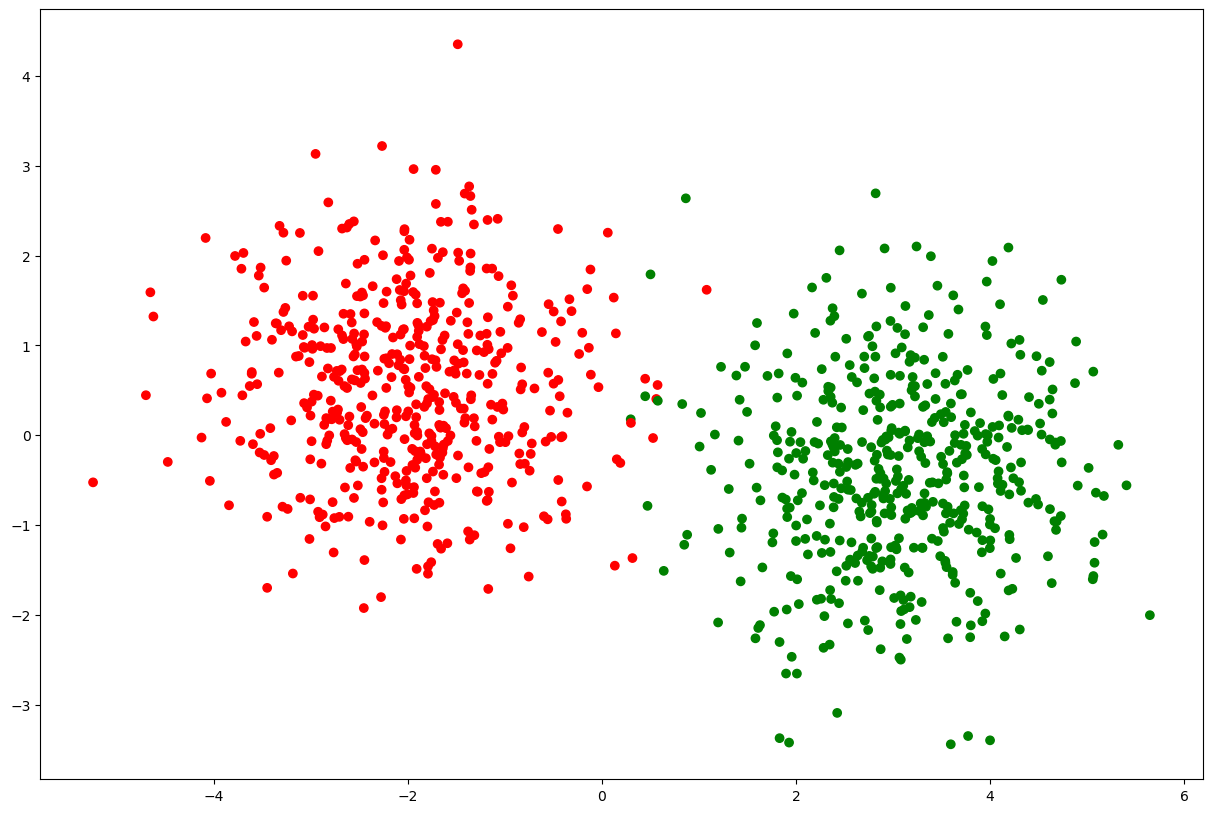

In [50]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)
#y = y.reshape(-1, 1)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y.ravel() == cl] = str(colors[i])

plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)

plt.show()

In [53]:
clf = MyElasticLogisticRegression(0.1, 0.1)
clf.fit(X, y, epochs=1000)
w = clf.get_weights()

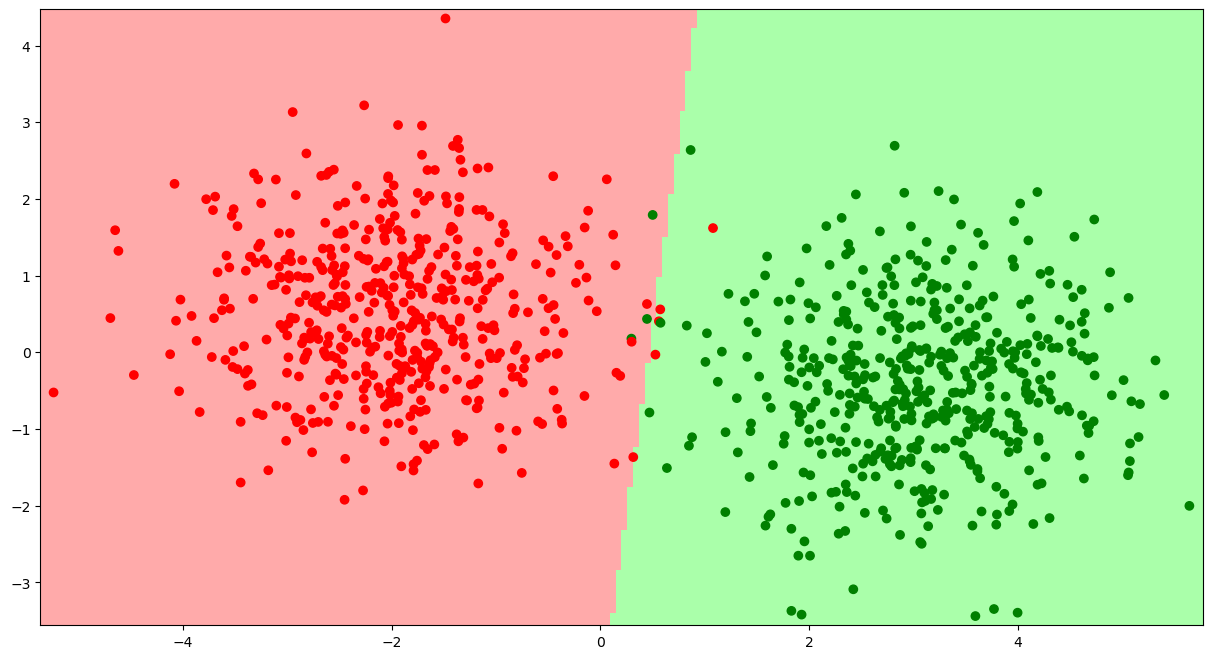

In [54]:
from matplotlib.colors import ListedColormap

eps = 0.1
xx, yy = np.meshgrid(
    np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
    np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200)
)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15,8))

plt.pcolormesh(xx, yy, Z, cmap=ListedColormap(["#FFAAAA", "#AAFFAA"]))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)

plt.show()

Теперь протестируем на датасете MNIST. Это очень простой класический датасет, на котором часто тестируются модели. С помощью нейронных сетей люди научились получать на нем качество 99.84%.

Датасет состоит из черно-белых картинок с цифрами. 
![mnist-3.0.1.png](https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Так как мы сделали классификатор для двух классов, то выберем из всех картинок только картинки 0 и 1, превратим их из двумерной матрицы в вектор и обучим нашу модель.

In [55]:
data = pd.read_csv('./train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Данные выглядят как таблица, первая колонка которой это лейбел -- цифра, которая изображена на картинке, а следующие 784 колонки это значения от 0 до 255, описывающие все пиксели картинки 28х28. То есть нам не придется делать reshape и превращать матрицу в вектор, так как это уже сделано.

In [56]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# Выберем только картинки, где изображен 0 и 1
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

Для оценки модели мы используем кросс валидацию.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = MyElasticLogisticRegression(0.1, 0.1)
pipeline = make_pipeline(StandardScaler(), clf)

scores = cross_val_score(pipeline, X, y, cv=3, scoring="accuracy")
print(f"Mean accuracy of Logistic Regression for two classes is {scores.mean()}")